In [10]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import gridspec
import math

### Rappresentazione dei dati

In [8]:
events = []
for m in range(9, 13):
    for d in range(1, 32):
        if m<10 and d<10:
            fp = 'Eventi/Muoni_Eventi_2016_0{}_0{}.txt'.format(m, d)
        elif m<10 and d>=10:
            fp = 'Eventi/Muoni_Eventi_2016_0{}_{}.txt'.format(m, d)
        elif m>=10 and d<10:
            fp = 'Eventi/Muoni_Eventi_2016_{}_0{}.txt'.format(m, d)
        elif m>=10 and d>=10:
            fp = 'Eventi/Muoni_Eventi_2016_{}_{}.txt'.format(m, d)
        events.append(fp)

In [10]:
evts_bin = []
for file in events:
    try:
        data = open(file, 'r')
        raw = data.readlines()
        lines = [raw[i:i+3] for i in range(0, len(raw)-2, 3)]
        for line in lines:
            master, slave = line[2], line[1]
            x_hex = [master[i:i+3] for i in range(0, len(master)-2, 3)]
            y_hex = [slave[i:i+3] for i in range(0, len(slave)-2, 3)]
            x_bin = [f'{int(x,16):0>12b}' for x in x_hex]
            y_bin = [f'{int(y,16):0>12b}' for y in y_hex]
            evts_bin.append(np.array([x_bin, y_bin]))
    except: None
evts_bin = np.array(evts_bin)

In [11]:
Master = pd.DataFrame(evts_bin[:,0], columns = ['x{:}'.format(n) for n in range(10)])
Slave = pd.DataFrame(evts_bin[:,1], columns = ['y{:}'.format(n) for n in range(10)])

In [12]:
d = 4
master, slave = evts_bin[:,0], evts_bin[:,1]
def bin_to_cartesian(a, d):
    X = []
    for e in a:
        track = []
        for i in range(10):
            num, den = 0, 0
            for j in range(10):
                num += int(e[i][j+2])*(2 + j*d)
                den += int(e[i][j+2])
            try: x = num/den
            except: x = np.nan
            finally: track.append(x)
        X.append(track)
    return X
xz = bin_to_cartesian(master, d)
yz = bin_to_cartesian(slave, d)

In [13]:
XZ = pd.DataFrame(xz, columns = ['x{:}'.format(n) for n in range(10)])
YZ = pd.DataFrame(yz, columns = ['y{:}'.format(n) for n in range(10)])

In [14]:
def vertical_angle(a, h):
    z = pd.Series([h*j for j in range(10)], index = a.index)
    valid_a = a[np.isfinite(a)]
    valid_z = z[np.isfinite(a)]
    def slope(x, y):
        if x.size<=2:
            return np.nan
        elif x.size>2:
            cov = (x*y).mean() - x.mean()*y.mean()
            var = (x**2).mean() - x.mean()**2
            return cov/var
    m = slope(valid_z, valid_a)
    return np.arctan(m)

In [15]:
h = 7
theta_x = np.array([vertical_angle(row, h) for _,row in XZ.iterrows()])
theta_y = np.array([vertical_angle(row, h) for _,row in YZ.iterrows()])

In [46]:
data16 = pd.DataFrame({'theta_x': theta_x, 'theta_y': theta_y})
data16.to_csv('data16')

### Calcolo dell'efficienza

### Calcolo di $\Delta T$

In [19]:
datetimes = []
for m in range(9, 13):
    for d in range(1, 32):
        if m<10 and d<10:
            fp = 'Eventi/Muoni_Orario_2016_0{}_0{}.txt'.format(m, d)
        elif m<10 and d>=10:
            fp = 'Eventi/Muoni_Orario_2016_0{}_{}.txt'.format(m, d)
        elif m>=10 and d<10:
            fp = 'Eventi/Muoni_Orario_2016_{}_0{}.txt'.format(m, d)
        elif m>=10 and d>=10:
            fp = 'Eventi/Muoni_Orario_2016_{}_{}.txt'.format(m, d)
        datetimes.append(fp)

In [21]:
durations = []
for file in datetimes:
    try:
        temp = pd.read_table(file, sep = r'\s+', names = ['event_id','time','theta_x','theta_y'])
        time = pd.to_timedelta(temp.time)
        timemin, timemax = time.min(), time.max()
        deltatime = timemax - timemin
        durations.append(deltatime)
    except:
        None
t_tot = round(pd.Series(durations).sum().total_seconds()/60, 0)

In [23]:
print('Δt = ', t_tot, 'min')

Δt =  104372.0 min


### Calcolo dell'accettanza

In [12]:
l = 0.4
h = 0.07
n_p = 10
n_mc = 100000
n_hit = 0
theta_tot, phi_tot = [], []
theta_hit, phi_hit = [], []
for i in range(n_p):
    theta = np.arccos((1 - np.random.uniform(size = n_mc))**(1/3))
    phi = 2*math.pi*np.random.uniform(size = n_mc)
    st, ct, sp, cp = np.sin(theta), np.cos(theta), np.sin(phi), np.cos(phi)
    us, vs, ws = st*cp, st*sp, ct
    x0s = np.random.uniform(-l/2, l/2, size = n_mc)
    y0s = np.random.uniform(-l/2, l/2, size = n_mc)
    z0s = np.full(n_mc, i*h)
    x1s = np.array([[x0 + (j*h-z0)*(u/w) for j in range(n_p)] for x0, z0, u, w in zip(x0s, z0s, us, ws)])
    y1s = np.array([[y0 + (j*h-z0)*(v/w) for j in range(n_p)] for y0, z0, v, w in zip(y0s, z0s, vs, ws)])
    hits = [((x>-l/2) & (x<l/2) & (y>-l/2) & (y<l/2)) for x, y in zip(x1s, y1s)]
    theta_tot.append(theta)
    phi_tot.append(phi) 
    for hit, th, ph in zip(hits, theta, phi):
        if len(hit[hit==1])>2:
            n_hit+=1
            theta_hit.append(th)
            phi_hit.append(ph)
print("{:d}/{:d}".format(n_hit, n_mc*n_p))
acc = n_hit/(n_mc*n_p)
err = np.sqrt(acc*(1 - acc)/(n_mc*n_p))
print("A = {:.4f}±{:.4f}".format(acc, err))

815149/1000000
A = 0.8151±0.0004


In [13]:
theta_tot = np.array(theta_tot).reshape(-1)
phi_tot = np.array(phi_tot).reshape(-1)

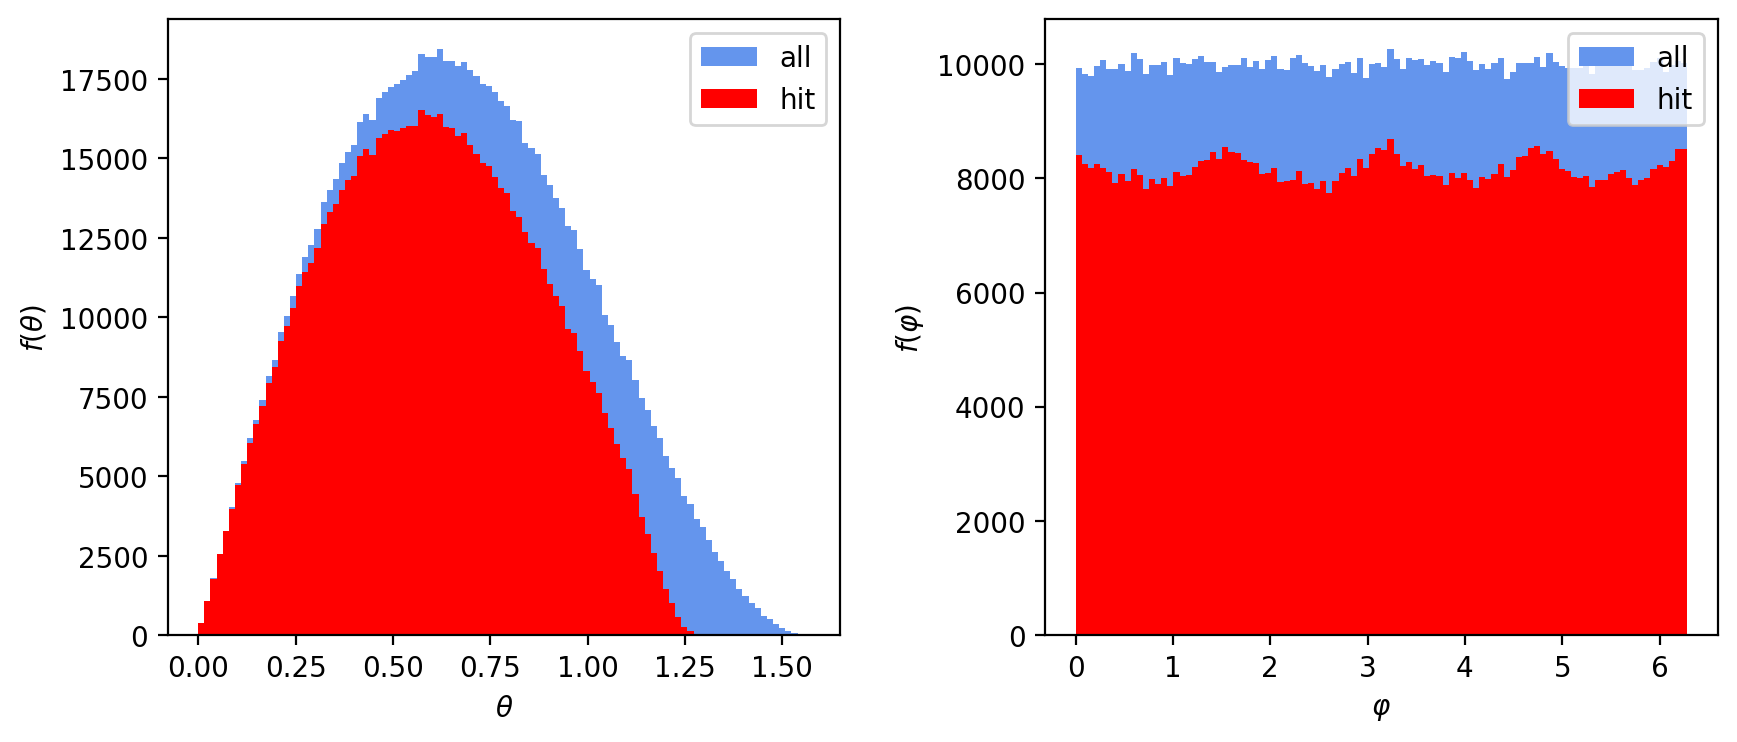

In [14]:
fig = plt.figure(figsize = (10, 4), dpi=200)
gs = gridspec.GridSpec(1, 9)
ax0 = fig.add_subplot(gs[:, :4])
ax1 = fig.add_subplot(gs[:, 5:])
nbins = 100

theta_range=[0, np.pi/2]
n_th_t, bins_th, _ = ax0.hist(theta_tot, density=False, bins=nbins, range=theta_range, color='cornflowerblue', label='all')
n_th_h, _, _ = ax0.hist(theta_hit, density=False, bins=nbins, range=theta_range, color='red', label='hit')
ax0.set(xlabel=r'$\theta$', ylabel=r'$f(\theta)$')
ax0.legend()

phi_range=[0, 2*np.pi]
n_ph_t, bins_ph, _ = ax1.hist(phi_tot, density=False, bins=nbins, range=phi_range, color='cornflowerblue', label='all')
n_ph_h, _, _ = ax1.hist(phi_hit, density=False, bins=nbins, range=phi_range, color='red', label='hit')
ax1.set(xlabel=r'$\varphi$', ylabel=r'$f(\varphi)$')
ax1.legend()

plt.show()

In [16]:
th, ph = (bins_th[1:]+bins_th[:-1])/2, (bins_ph[1:]+bins_ph[:-1])/2
delta_th = bins_th[1] - bins_th[0]
delta_ph = bins_ph[1] - bins_ph[0]
a_th = np.divide(n_th_h, n_th_t, out=np.zeros_like(n_th_t), where=n_th_t != 0)
a_ph = np.divide(n_ph_h, n_ph_t, out=np.zeros_like(n_ph_t), where=n_ph_t != 0)

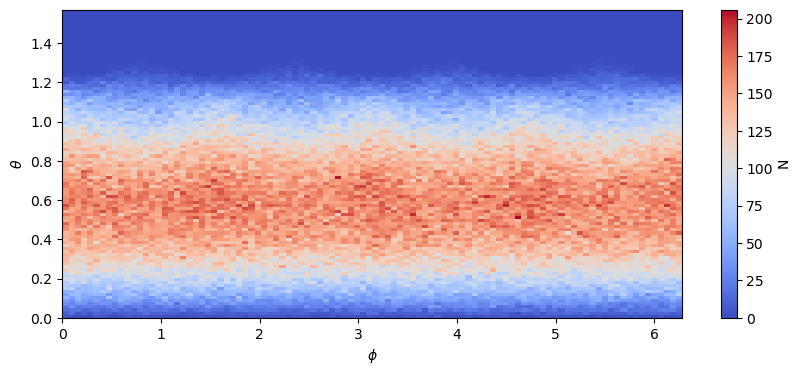

In [61]:
fig, ax = plt.subplots(figsize = (10, 4))
nbins = 100
phi_range = (0, 2*np.pi)
theta_range = (0, np.pi/2)
h_h, phi_edges, theta_edges, im = ax.hist2d(phi_hit, theta_hit, nbins,
                                          range = (phi_range, theta_range), density = False, cmap = 'coolwarm')
fig.colorbar(im, ax = ax, label = r'$\mathrm{N}$')
ax.set(xlabel = r'$\phi$', ylabel = r'$\theta$')
plt.show()

### Calcolo del numero atteso di muoni a cielo aperto

In [28]:
t_tot = 104372 #min
n = 10 #plates
l = 40 #cm
I0 = 1 #muon/cm2/min
acc = 0.8153
err = 0.0004

In [29]:
S_tot = n*l**2
N_fs = round(S_tot*t_tot*I0, -1)
print('N_fs = ', N_fs)

N_fs =  1669952000


In [30]:
def model_th(x):
    return 3*np.sin(x)*np.cos(x)**2

In [81]:
f_th = model_th(th)
N_fs_th = N_fs*delta_th*a_th*f_th
N_fs_ph = N_fs*delta_ph*a_ph/2/np.pi

In [82]:
df = pd.read_csv('data16')
theta_x = df.theta_x[np.isfinite(df.theta_y)][np.isfinite(df.theta_x)]
theta_y = df.theta_y[np.isfinite(df.theta_x)][np.isfinite(df.theta_y)]
mx = np.tan(theta_x)
my = np.tan(theta_y)
th_m = np.arccos(1/np.sqrt(mx**2+my**2+1))
ph_m = np.arctan2(my, mx)+np.pi

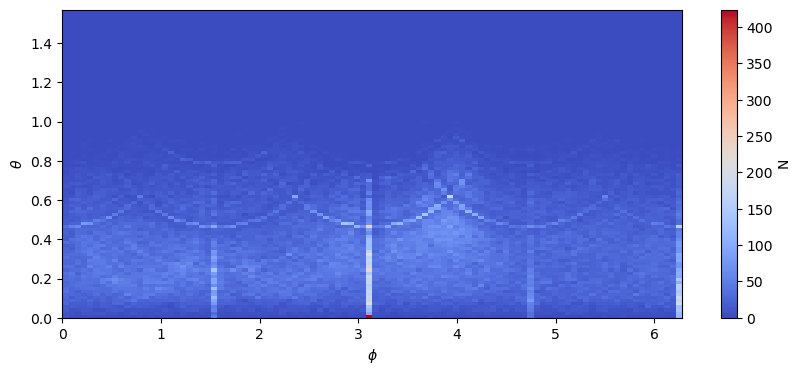

In [83]:
fig, ax = plt.subplots(figsize = (10, 4))
nbins = 100
phi_range = (0, 2*np.pi)
theta_range = (0, np.pi/2)
h_m, phi_edges, theta_edges, im = ax.hist2d(ph_m, th_m, nbins,
                                          range = (phi_range, theta_range), density = False, cmap = 'coolwarm')
fig.colorbar(im, ax = ax, label = r'$\mathrm{N}$')
ax.set(xlabel = r'$\phi$', ylabel = r'$\theta$')
plt.show()

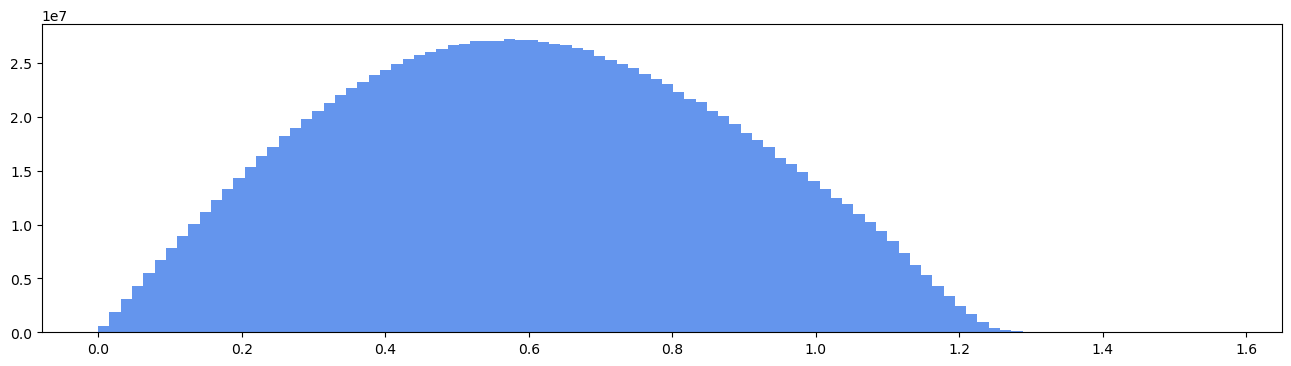

In [84]:
fig = plt.figure(figsize = (16, 4), dpi=100)
plt.bar(th, N_fs_th, width = delta_th, bottom=0, align='center', color='cornflowerblue')
n_th_m, bins_th_m, _ = plt.hist(th_m, density=False, bins=nbins, range=theta_range, color='red')
plt.show()

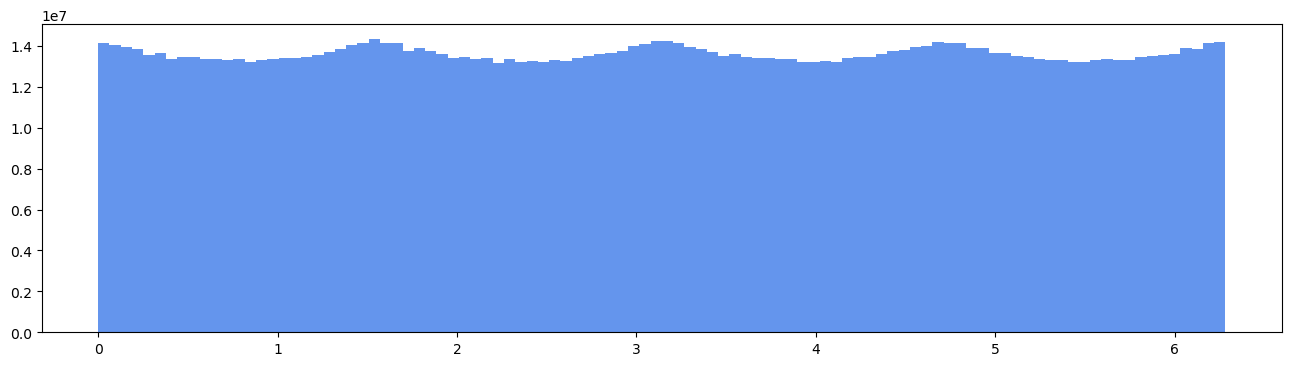

In [85]:
fig = plt.figure(figsize = (16, 4), dpi=100)
plt.bar(ph, N_fs_ph, width = delta_ph, bottom=0, align='center', color='cornflowerblue')
n_ph_m, bins_ph_m, _ = plt.hist(ph_m, density=False, bins=nbins, range=phi_range, color='red')
plt.show()

### Calcolo dell'attenuazione

In [87]:
import statsmodels.stats.proportion as proportion

In [88]:
T_th = np.divide(n_th_m, N_fs_th, out=np.zeros_like(N_fs_th), where=N_fs_th != 0)
T_ph = np.divide(n_ph_m, N_fs_ph, out=np.zeros_like(N_fs_ph), where=N_fs_ph != 0)

In [89]:
cl = 0.6827
alpha = 1 - cl
int_th = np.array([proportion.proportion_confint(n, N, alpha=alpha, method='beta') 
                   for n, N in zip(n_th_m[N_fs_th>0], N_fs_th[N_fs_th>0])])
int_ph = np.array([proportion.proportion_confint(n, N, alpha=alpha, method='beta') 
                   for n, N in zip(n_ph_m[N_fs_ph>0], N_fs_ph[N_fs_ph>0])])
err_th = np.array([T_th[N_fs_th>0]-int_th[:,0], int_th[:,1]-T_th[N_fs_th>0]])
err_ph = np.array([T_ph[N_fs_ph>0]-int_ph[:,0], int_ph[:,1]-T_ph[N_fs_ph>0]])

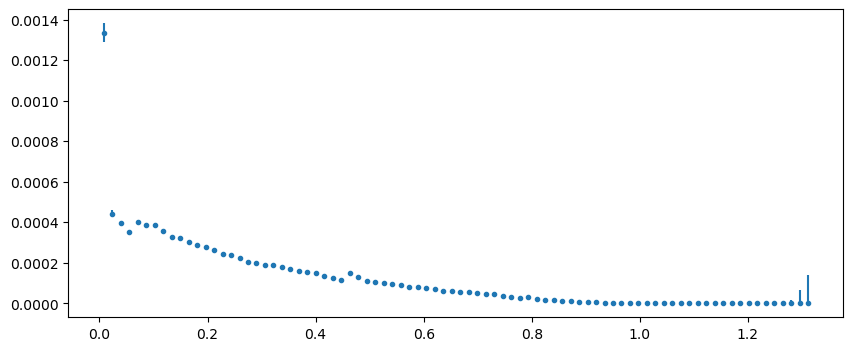

In [90]:
fig = plt.figure(figsize = (10, 4), dpi=100)
plt.errorbar(th[N_fs_th>0], T_th[N_fs_th>0], err_th, fmt='.')
plt.show()

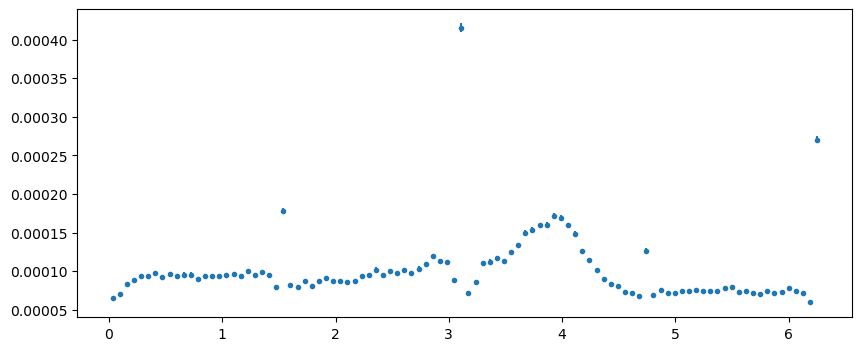

In [91]:
fig = plt.figure(figsize = (10, 4), dpi=100)
plt.errorbar(ph[N_fs_ph>0], T_ph[N_fs_ph>0], err_ph, fmt='.')
plt.show()

In [92]:
A = np.divide(h_m, h_h, out=np.zeros_like(h_h), where=h_h!=0)
int_A = np.array([proportion.proportion_confint(h, H, alpha=alpha, method='beta') 
                   for h, H in zip(h_m[h_h>0], h_h[h_h>0])])
err_A = np.array([A[h_h>0]-int_A[:,0], int_A[:,1]-A[h_h>0]])

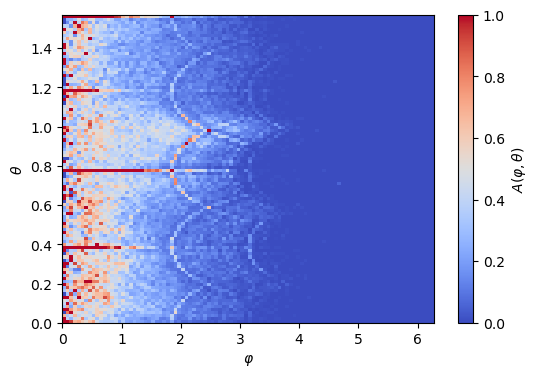

In [118]:
x, y = np.meshgrid(ph, th)
fig, ax = plt.subplots(figsize=(6, 4))
c = ax.pcolor(x, y, A, cmap='coolwarm', vmin=0, vmax=1)
bar = fig.colorbar(c, ax=ax)
plt.xlabel(r'$\varphi$')
plt.ylabel(r'$\theta$')
bar.set_label(r'$A(\varphi, \theta)$')
plt.show()